### Intuitive Understanding of PCA

Imagine you have a dataset of student performance with two features:
- Hours studied
- Test scores

These features are likely correlated (more study → higher scores). PCA will:

1. **Find the direction of maximum variance** (the diagonal line showing the general trend)
2. **Create a new axis** (PC1) along this direction
3. **Create a perpendicular axis** (PC2) for remaining variance
4. **PC1 captures most information**, so we can often drop PC2

### Key Properties of PCA

✅ **Preserves global structure** - maintains overall relationships  
✅ **Deterministic** - same result every time  
✅ **Fast and scalable** - works well on large datasets  
✅ **Interpretable** - components are linear combinations of original features  
❌ **Assumes linearity** - may miss complex non-linear patterns  
❌ **Sensitive to scaling** - must standardize features first  
❌ **Not great for visualization** of complex manifolds

### Variance Explained

The **explained variance ratio** tells us how much information each PC captures:

$$\text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{d} \lambda_j}$$

We typically aim to retain 90-95% of total variance.

## 2. Principal Component Analysis (PCA) - Theory

### What is PCA?

PCA is a **linear dimensionality reduction** technique that:
- Finds the directions (principal components) of maximum variance in the data
- Projects data onto these directions
- Keeps the first few components that capture most variance

### Mathematical Foundation

#### Step 1: Standardize the Data
Given data matrix $X$ with $n$ samples and $d$ features:

$$X_{standardized} = \frac{X - \mu}{\sigma}$$

where $\mu$ is the mean and $\sigma$ is the standard deviation of each feature.

#### Step 2: Compute the Covariance Matrix
$$C = \frac{1}{n-1} X^T X$$

The covariance matrix captures how features vary together.

#### Step 3: Eigendecomposition
Find eigenvalues $\lambda$ and eigenvectors $v$ such that:

$$Cv = \lambda v$$

- **Eigenvalues** ($\lambda$): Represent the amount of variance captured by each principal component
- **Eigenvectors** ($v$): Define the direction of each principal component

#### Step 4: Sort and Select Components
- Sort eigenvectors by eigenvalues (descending)
- Select top $k$ eigenvectors to form projection matrix $W$

#### Step 5: Transform the Data
$$X_{PCA} = XW$$

This projects the original data onto the new principal component space.

## 1. Introduction to Dimensionality Reduction

### What is Dimensionality Reduction?

**Dimensionality reduction** is the process of reducing the number of features (dimensions) in a dataset while preserving as much information as possible.

### Why Do We Need It?

1. **Curse of Dimensionality**: As dimensions increase, data becomes sparse and distances lose meaning
2. **Visualization**: Hard to visualize data beyond 3 dimensions
3. **Computational Efficiency**: Fewer features = faster training
4. **Remove Noise**: Eliminate irrelevant or redundant features
5. **Avoid Overfitting**: Reduce model complexity

### Types of Dimensionality Reduction

1. **Linear Methods**: PCA, LDA, ICA
2. **Non-linear Methods**: t-SNE, UMAP, Autoencoders, Kernel PCA

Today we'll focus on the three most popular techniques: **PCA**, **t-SNE**, and **UMAP**.

# Dimensionality Reduction: A Comprehensive Tutorial

**Duration: ~50 minutes**

## Table of Contents
1. Introduction to Dimensionality Reduction (5 min)
2. Principal Component Analysis (PCA) Theory (15 min)
3. PCA Implementation & ML Model Comparison (15 min)
4. t-SNE Visualization (7 min)
5. UMAP Visualization (8 min)

---

## 3. PCA Implementation & ML Model Comparison

Let's implement PCA and see how it affects machine learning model performance!

We'll use the **Breast Cancer Wisconsin dataset** - a classification problem with 30 features.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


### Step 1: Load and Explore the Data

In [2]:
# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Classes: {data.target_names}")
print(f"\nFeature names (first 10):")
print(data.feature_names[:10])

Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569
Classes: ['malignant' 'benign']

Feature names (first 10):
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension']


### Step 2: Split and Standardize Data

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set: (455, 30)
Test set: (114, 30)


### Step 3: Train Model BEFORE PCA (Baseline)

In [4]:
def count_mlp_params(model):
    """Count total trainable parameters in an MLPClassifier."""
    return sum(c.size + b.size for c, b in zip(model.coefs_, model.intercepts_))



mlp_before = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                            max_iter=500, random_state=42)
mlp_before.fit(X_train_scaled, y_train)

# Make predictions
y_pred_before = mlp_before.predict(X_test_scaled)

# Evaluate
f1_before = f1_score(y_test, y_pred_before)
n_params_before = count_mlp_params(mlp_before)

print(f"\nArchitecture: 30 → 64 → 32 → 1")
print(f"Total parameters: {n_params_before:,}")
print(f"F1 Score (weighted): {f1_before:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_before, target_names=data.target_names))




Architecture: 30 → 64 → 32 → 1
Total parameters: 4,097
F1 Score (weighted): 0.9718

Classification Report:
              precision    recall  f1-score   support

   malignant       0.93      0.98      0.95        42
      benign       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



### Step 4: Apply PCA and Analyze Components

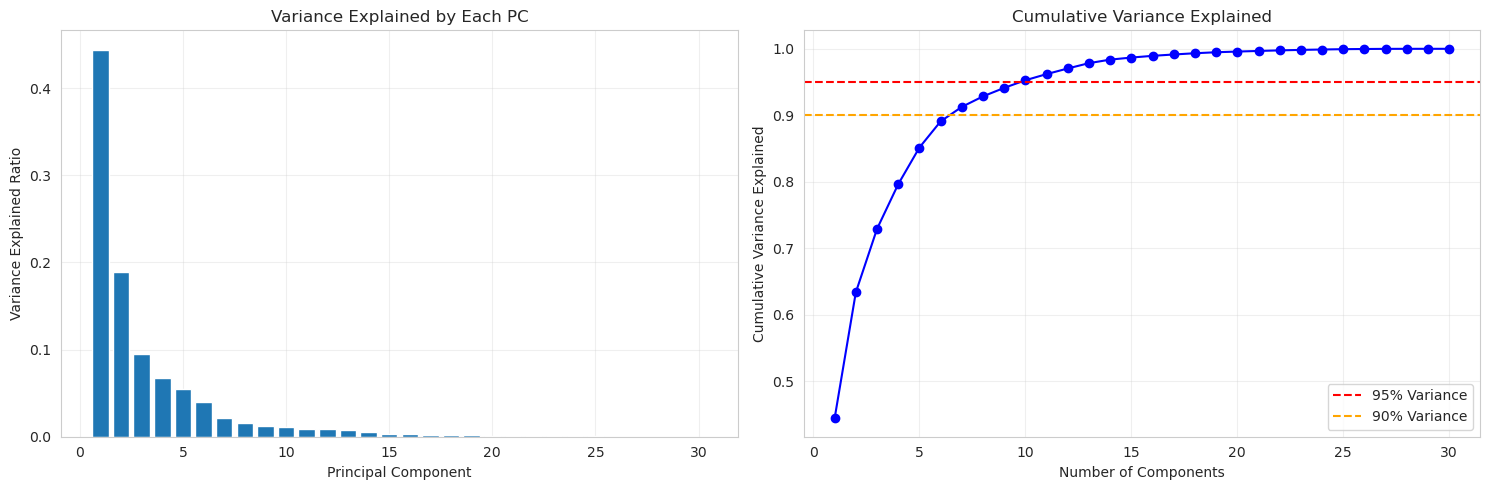

In [5]:
# First, let's see how much variance each component explains
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained Ratio')
axes[0].set_title('Variance Explained by Each PC')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), 
             cumulative_variance, 'bo-')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [6]:
# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nTo capture 95% of variance, we need {n_components_95} components (out of 30)")
print(f"To capture 90% of variance, we need {np.argmax(cumulative_variance >= 0.90) + 1} components")
print(f"\nFirst 5 components explain: {cumulative_variance[4]:.2%} of variance")


To capture 95% of variance, we need 10 components (out of 30)
To capture 90% of variance, we need 7 components

First 5 components explain: 85.14% of variance


### Step 5: Apply PCA with Optimal Number of Components

In [7]:
# Apply PCA with components that capture 95% variance
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original shape: {X_train_scaled.shape}")
print(f"After PCA: {X_train_pca.shape}")
print(f"Dimensionality reduction: {X_train_scaled.shape[1]} → {X_train_pca.shape[1]} features")
print(f"Reduction: {(1 - X_train_pca.shape[1]/X_train_scaled.shape[1])*100:.1f}%")

Original shape: (455, 30)
After PCA: (455, 10)
Dimensionality reduction: 30 → 10 features
Reduction: 66.7%


### Step 6: Train Model AFTER PCA

In [8]:
# Train Neural Network (MLP) on PCA-reduced features
print("=" * 60)
print(f"MODEL PERFORMANCE AFTER PCA ({n_components_95} features)")
print("=" * 60)

mlp_after = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                           max_iter=500, random_state=42)
mlp_after.fit(X_train_pca, y_train)

# Make predictions
y_pred_after = mlp_after.predict(X_test_pca)

# Evaluate
f1_after = f1_score(y_test, y_pred_after)
n_params_after = count_mlp_params(mlp_after)

print(f"\nArchitecture: {n_components_95} → 64 → 32 → 1")
print(f"Total parameters: {n_params_after:,}")
print(f"F1 Score (weighted): {f1_after:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_after, target_names=data.target_names))


MODEL PERFORMANCE AFTER PCA (10 features)

Architecture: 10 → 64 → 32 → 1
Total parameters: 2,817
F1 Score (weighted): 0.9645

Classification Report:
              precision    recall  f1-score   support

   malignant       0.91      0.98      0.94        42
      benign       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



### Step 7: Compare Results

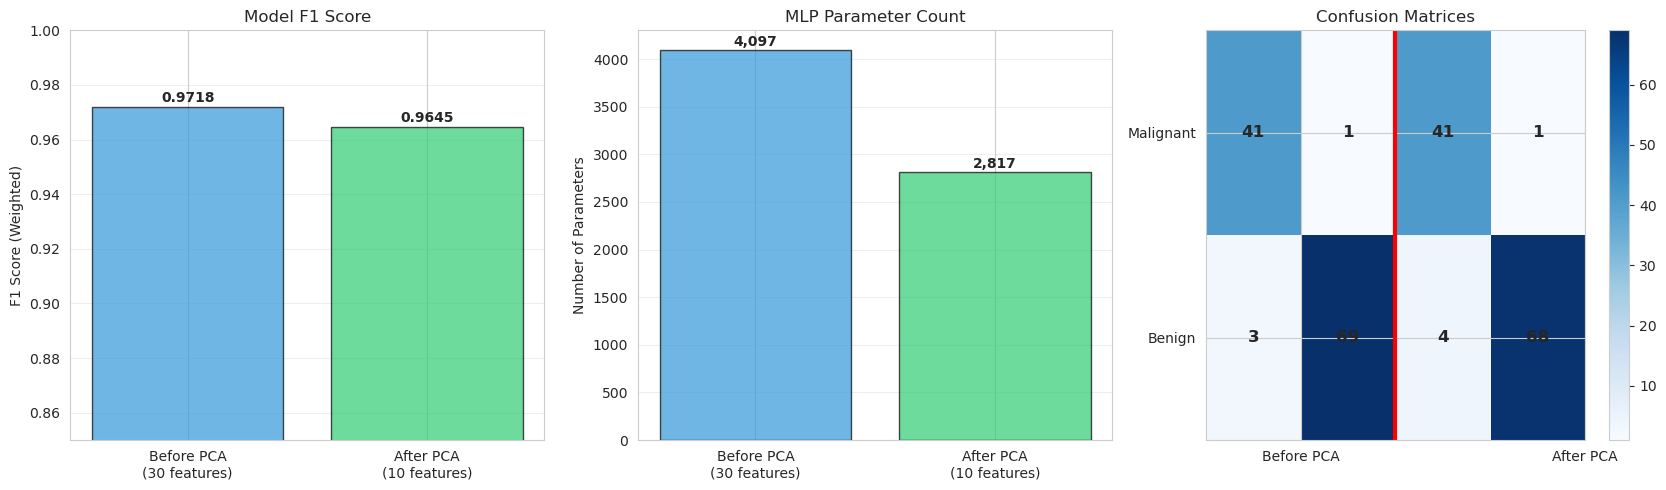


SUMMARY: MLP BEFORE vs AFTER PCA

Metric                       Before PCA             After PCA             
------------------------------------------------------------------------
Architecture                 30→64→32→1             10→64→32→1            
Input Features               30                     10                    
# Parameters                 4,097                  2,817                 
Parameter Reduction          -                      31.2%
F1 Score (weighted)          0.9718                 0.9645                
F1 Score Change              -                      -0.73%

✅ Key Insights:
   • Reduced input features by 66.7% while retaining 95% variance
   • MLP parameters reduced: 4,097 → 2,817 (31.2% fewer)
   • F1 Score change: -0.73%


In [9]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

methods = ['Before PCA\n(30 features)', f'After PCA\n({n_components_95} features)']
colors = ['#3498db', '#2ecc71']

# 1. F1 Score comparison
f1_scores = [f1_before, f1_after]
axes[0].bar(methods, f1_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('F1 Score (Weighted)')
axes[0].set_title('Model F1 Score')
axes[0].set_ylim([0.85, 1.0])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Parameter count comparison
n_params = [n_params_before, n_params_after]
axes[1].bar(methods, n_params, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Parameters')
axes[1].set_title('MLP Parameter Count')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(n_params):
    axes[1].text(i, v + max(n_params)*0.01, f'{v:,}', ha='center', fontweight='bold')

# 3. Confusion matrices
cm_before = confusion_matrix(y_test, y_pred_before)
cm_after = confusion_matrix(y_test, y_pred_after)

from matplotlib.patches import Rectangle
cm_comparison = np.concatenate([cm_before, cm_after], axis=1)
im = axes[2].imshow(cm_comparison, cmap='Blues', aspect='auto')

for i in range(2):
    for j in range(4):
        axes[2].text(j, i, str(cm_comparison[i, j]), ha='center', va='center',
                    fontweight='bold', fontsize=12)

axes[2].axvline(x=1.5, color='red', linewidth=3)
axes[2].set_xticks([0.5, 3.5])
axes[2].set_xticklabels(['Before PCA', 'After PCA'])
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Malignant', 'Benign'])
axes[2].set_title('Confusion Matrices')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 72)
print("SUMMARY: MLP BEFORE vs AFTER PCA")
print("=" * 72)
print(f"\n{'Metric':<28} {'Before PCA':<22} {'After PCA':<22}")
print("-" * 72)
print(f"{'Architecture':<28} {'30→64→32→1':<22} {f'{n_components_95}→64→32→1':<22}")
print(f"{'Input Features':<28} {30:<22} {n_components_95:<22}")
print(f"{'# Parameters':<28} {n_params_before:<22,} {n_params_after:<22,}")
print(f"{'Parameter Reduction':<28} {'-':<22} {(1 - n_params_after/n_params_before)*100:.1f}%")
print(f"{'F1 Score (weighted)':<28} {f1_before:<22.4f} {f1_after:<22.4f}")
print(f"{'F1 Score Change':<28} {'-':<22} {(f1_after-f1_before)*100:+.2f}%")

print("\n✅ Key Insights:")
print(f"   • Reduced input features by {100 * (1 - n_components_95/30):.1f}% while retaining 95% variance")
print(f"   • MLP parameters reduced: {n_params_before:,} → {n_params_after:,} ({(1-n_params_after/n_params_before)*100:.1f}% fewer)")
print(f"   • F1 Score change: {(f1_after-f1_before)*100:+.2f}%")


### Step 8: Visualize PCA - 2D Projection

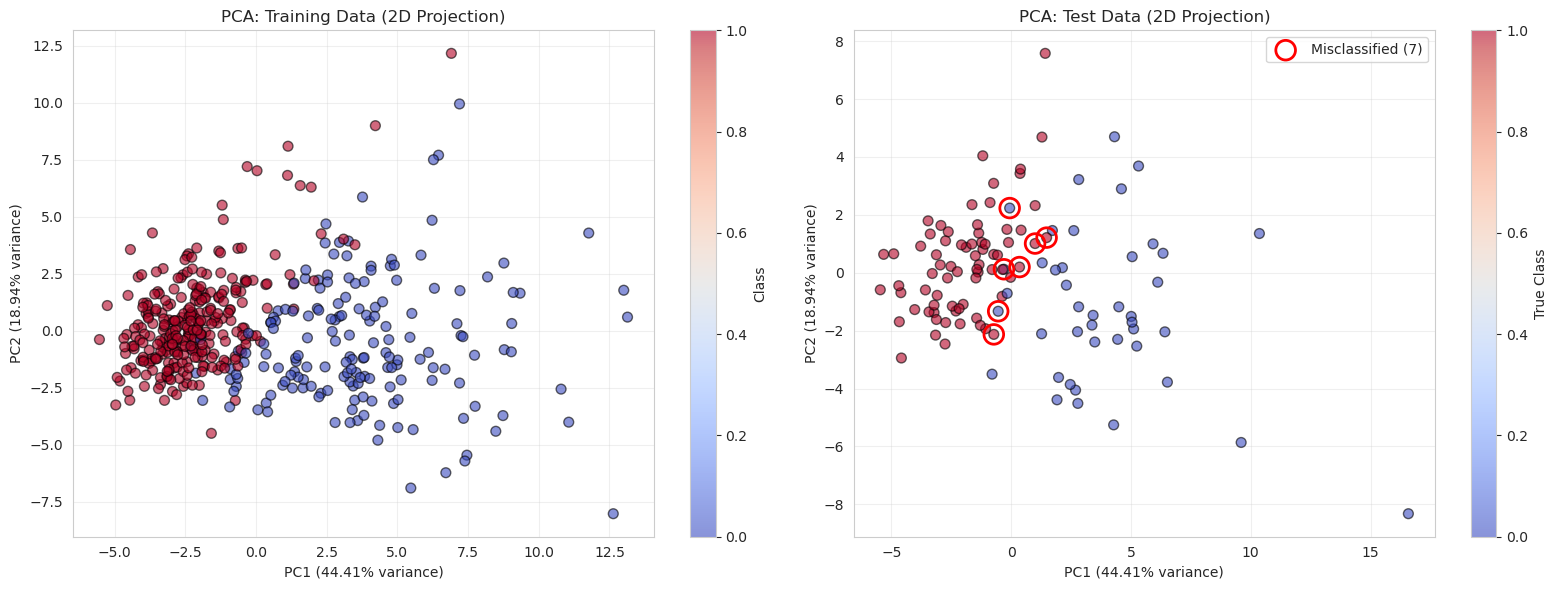


First 2 PCs explain 63.36% of total variance
2D MLP accuracy: 0.9386


In [10]:
# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_scaled)
X_test_2d = pca_2d.transform(X_test_scaled)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training data
scatter1 = axes[0].scatter(X_train_2d[:, 0], X_train_2d[:, 1], 
                          c=y_train, cmap='coolwarm', 
                          alpha=0.6, edgecolors='black', s=50)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('PCA: Training Data (2D Projection)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Class')

# Test data with predictions
scatter2 = axes[1].scatter(X_test_2d[:, 0], X_test_2d[:, 1], 
                          c=y_test, cmap='coolwarm', 
                          alpha=0.6, edgecolors='black', s=50)
# Mark misclassified points
mlp_2d = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                        max_iter=500, random_state=42)
mlp_2d.fit(X_train_2d, y_train)
y_pred_2d = mlp_2d.predict(X_test_2d)
misclassified = y_pred_2d != y_test
axes[1].scatter(X_test_2d[misclassified, 0], X_test_2d[misclassified, 1], 
               s=200, facecolors='none', edgecolors='red', linewidths=2,
               label=f'Misclassified ({misclassified.sum()})')

axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title('PCA: Test Data (2D Projection)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
plt.colorbar(scatter2, ax=axes[1], label='True Class')

plt.tight_layout()
plt.show()

print(f"\nFirst 2 PCs explain {pca_2d.explained_variance_ratio_.sum():.2%} of total variance")
print(f"2D MLP accuracy: {accuracy_score(y_test, y_pred_2d):.4f}")

---

## 4. t-SNE (t-Distributed Stochastic Neighbor Embedding)

### What is t-SNE?

**t-SNE** is a **non-linear dimensionality reduction** technique specifically designed for visualization:
- Preserves local structure (nearby points stay close)
- Great for discovering clusters in high-dimensional data
- Primarily used for 2D/3D visualization

### How t-SNE Works

1. **Measures similarities** between points in high-dimensional space
2. **Creates a probability distribution** over pairs of high-dimensional objects
3. **Creates a similar distribution** in low-dimensional space
4. **Minimizes the difference** between these distributions using gradient descent

### Key Parameters

- **perplexity**: Balances local vs global structure (typically 5-50)
- **learning_rate**: Step size for optimization (typically 10-1000)
- **n_iter**: Number of iterations (typically 1000+)

### When to Use t-SNE

✅ Visualizing high-dimensional data  
✅ Discovering clusters  
✅ Exploratory data analysis  
❌ Not for preprocessing (non-deterministic)  
❌ Not for measuring distances (distorts global structure)  
❌ Computationally expensive for large datasets

Loading MNIST dataset (may take a moment on first run)...
Full MNIST shape : (70000, 784)
Image size       : 28 x 28 pixels = 784 features
Classes          : [0 1 2 3 4 5 6 7 8 9]  (digits 0–9)

Subsample used   : 6000 images (600 per digit)
Class distribution:
  Digit 0: 600 samples
  Digit 1: 600 samples
  Digit 2: 600 samples
  Digit 3: 600 samples
  Digit 4: 600 samples
  Digit 5: 600 samples
  Digit 6: 600 samples
  Digit 7: 600 samples
  Digit 8: 600 samples
  Digit 9: 600 samples


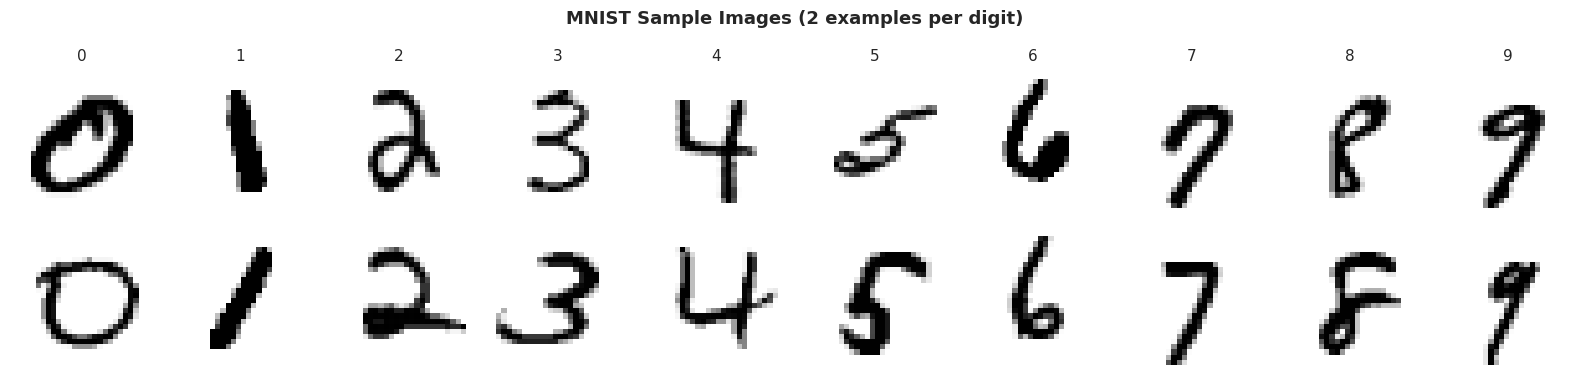

In [11]:
# Load MNIST via sklearn (downloads once, cached afterwards)
from sklearn.datasets import fetch_openml

print("Loading MNIST dataset (may take a moment on first run)...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist_full = mnist.data.astype(np.float32) / 255.0   # normalise to [0, 1]
y_mnist_full = mnist.target.astype(int)

print(f"Full MNIST shape : {X_mnist_full.shape}")
print(f"Image size       : 28 x 28 pixels = {X_mnist_full.shape[1]} features")
print(f"Classes          : {np.unique(y_mnist_full)}  (digits 0–9)")

# Subsample 6 000 images for fast t-SNE / UMAP (600 per digit, balanced)
N_SAMPLES = 6000
np.random.seed(42)
idx = np.concatenate([
    np.random.choice(np.where(y_mnist_full == d)[0], N_SAMPLES // 10, replace=False)
    for d in range(10)
])
np.random.shuffle(idx)
X_mnist = X_mnist_full[idx]
y_mnist = y_mnist_full[idx]

print(f"\nSubsample used   : {X_mnist.shape[0]} images ({N_SAMPLES // 10} per digit)")
print(f"Class distribution:")
for d in range(10):
    print(f"  Digit {d}: {(y_mnist == d).sum()} samples")

# Visualise a few sample images
fig, axes = plt.subplots(2, 10, figsize=(16, 4))
for digit in range(10):
    imgs = X_mnist[y_mnist == digit][:2]
    for row in range(2):
        axes[row, digit].imshow(imgs[row].reshape(28, 28), cmap='gray_r')
        axes[row, digit].axis('off')
        if row == 0:
            axes[row, digit].set_title(str(digit), fontsize=11)
plt.suptitle('MNIST Sample Images (2 examples per digit)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


### Load MNIST for t-SNE and UMAP Visualization

For t-SNE and UMAP we use **MNIST** — the "Hello World" of image datasets:
- **70 000** handwritten digit images (we subsample **6 000** for speed)
- Each image is **28 × 28 pixels = 784 features**
- **10 classes** (digits 0–9), perfectly balanced

MNIST is ideal for teaching because the expected result is well-known: t-SNE and UMAP should produce **10 distinct, well-separated clusters**, one per digit. Any deviation immediately shows the effect of a parameter change.

Running t-SNE with perplexity=5...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=50...


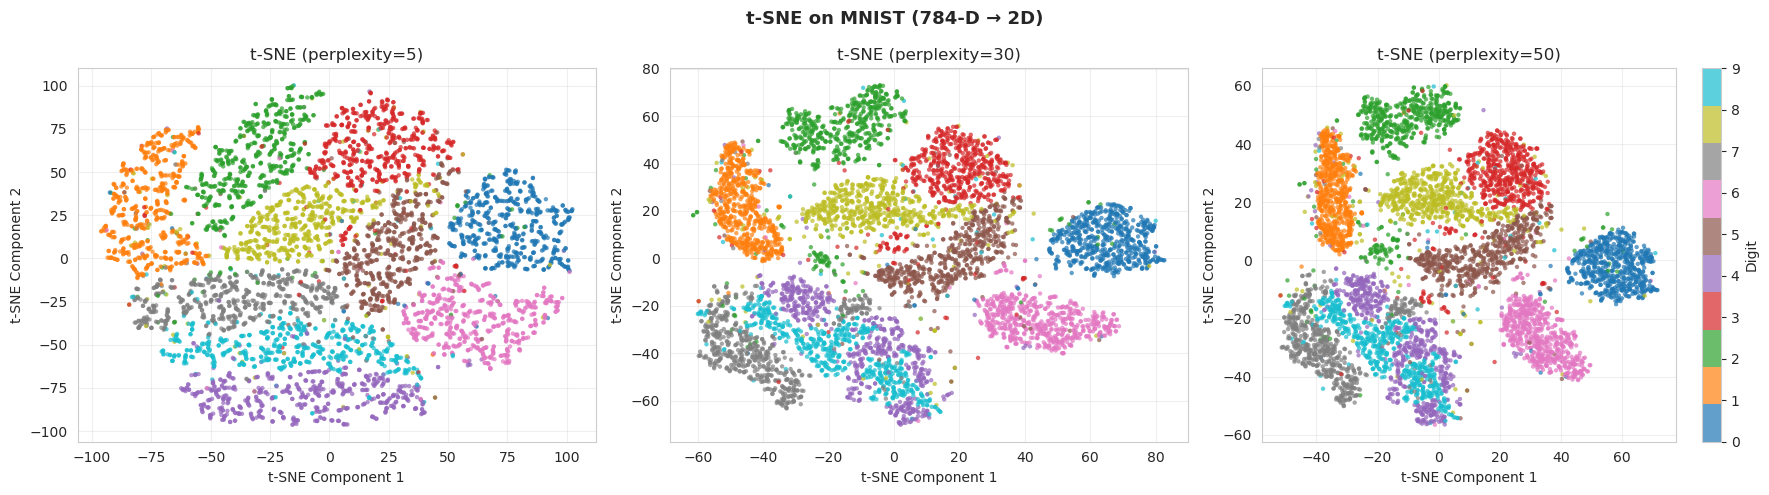


✅ t-SNE Observations:
   • Low perplexity (5): Very local structure — many tiny sub-clusters per digit
   • Medium perplexity (30): Classic result — 10 distinct, well-separated digit clusters
   • High perplexity (50): More global; clusters spread but still clearly separated
   • Similar-looking digits (3/5/8 or 4/9) appear closer in the 2D space!


In [12]:
# Import t-SNE
from sklearn.manifold import TSNE

# Apply t-SNE with different perplexity values on MNIST
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, perplexity in enumerate(perplexities):
    print(f"Running t-SNE with perplexity={perplexity}...")

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42,
                max_iter=1000, verbose=0)
    X_tsne = tsne.fit_transform(X_mnist)

    scatter = axes[idx].scatter(X_tsne[:, 0], X_tsne[:, 1],
                                c=y_mnist, cmap='tab10',
                                alpha=0.7, edgecolors='none', s=10)
    axes[idx].set_xlabel('t-SNE Component 1')
    axes[idx].set_ylabel('t-SNE Component 2')
    axes[idx].set_title(f't-SNE (perplexity={perplexity})')
    axes[idx].grid(True, alpha=0.3)

    if idx == 2:
        cbar = plt.colorbar(scatter, ax=axes[idx], ticks=range(10))
        cbar.set_label('Digit', fontsize=10)

plt.suptitle('t-SNE on MNIST (784-D → 2D)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ t-SNE Observations:")
print("   • Low perplexity (5): Very local structure — many tiny sub-clusters per digit")
print("   • Medium perplexity (30): Classic result — 10 distinct, well-separated digit clusters")
print("   • High perplexity (50): More global; clusters spread but still clearly separated")
print("   • Similar-looking digits (3/5/8 or 4/9) appear closer in the 2D space!")



### t-SNE Parameters Explained

#### 🔧 `perplexity` (default = 30)
Think of perplexity as **"how many neighbors each point cares about"**.

- Internally, it controls the width of the Gaussian distribution placed around each point when computing similarities in high-dimensional space
- **Low perplexity (5–10)**: Each point only considers a very small neighborhood → produces many tiny, fragmented sub-clusters
- **Medium perplexity (20–50)**: Balanced view → the classic well-separated cluster result
- **High perplexity (50–100)**: Each point considers a large neighborhood → more global layout, clusters may merge or spread

> 💡 Rule of thumb: perplexity ≈ `sqrt(n_samples)`. For 6,000 points, ~77 is a reasonable upper bound. Values between 20–50 work well in practice.

---

#### 🔧 `learning_rate` (default = "auto" ≈ 200)
Controls how aggressively points move during gradient descent optimization.

- **Too low**: Points clump together into a single dense ball — the embedding collapses
- **Too high**: Points scatter randomly with no meaningful structure
- The default `"auto"` (= `max(N/early_exaggeration, 50)`) works well in most cases

---

#### 🔧 `max_iter` / `n_iter` (default = 1000)
Number of gradient descent steps during optimization.

- **Too few**: The embedding hasn't converged — clusters may still be merging/separating
- **1000** is usually enough for datasets up to ~10,000 points
- Larger datasets may need 2000–5000 for stable results

---

#### 🔧 `n_components` (default = 2)
The number of output dimensions. Almost always kept at **2** for visualization.  
3D t-SNE is possible but rarely used — the 3D plots are harder to interpret than 2D.

---

#### ⚠️ Important Caveats
- **Distances between clusters are NOT meaningful** — two clusters being far apart in 2D does NOT mean they are far apart in the original space
- **Cluster sizes are NOT meaningful** — a large cluster is not necessarily more variable than a small one
- **Run it multiple times** — t-SNE is stochastic; use `random_state` for reproducibility


---

## 5. UMAP (Uniform Manifold Approximation and Projection)

### What is UMAP?

**UMAP** is a modern **non-linear dimensionality reduction** technique that:
- Preserves both local AND global structure (better than t-SNE)
- Much faster than t-SNE on large datasets
- Can be used for both visualization and preprocessing
- Based on manifold learning and topological data analysis

### How UMAP Works

1. **Constructs a high-dimensional graph** representation of the data
2. **Uses manifold learning theory** to model the data structure
3. **Optimizes a low-dimensional graph** to be as similar as possible
4. **Preserves topological structure** better than t-SNE

### Key Parameters

- **n_neighbors**: Size of local neighborhood (2-100, default=15)
- **min_dist**: Minimum distance between points in low-D space (0.0-0.99, default=0.1)
- **metric**: Distance metric to use (euclidean, cosine, etc.)

### UMAP vs t-SNE

| Feature | UMAP | t-SNE |
|---------|------|-------|
| Speed | ⚡ Faster | Slower |
| Global Structure | ✅ Better preserved | ❌ Distorted |
| Deterministic | ✅ More consistent | ❌ Varies |
| Scalability | ✅ Better for large data | ⚠️ Limited |
| Use for ML | ✅ Yes | ❌ No |

In [13]:
# Install UMAP if not already installed
# !pip install umap-learn

# Import UMAP
import umap

print("UMAP version:", umap.__version__)

/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP version: 0.5.7


### UMAP with Different Parameters

Running UMAP with n_neighbors=5...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with n_neighbors=15...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with n_neighbors=50...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


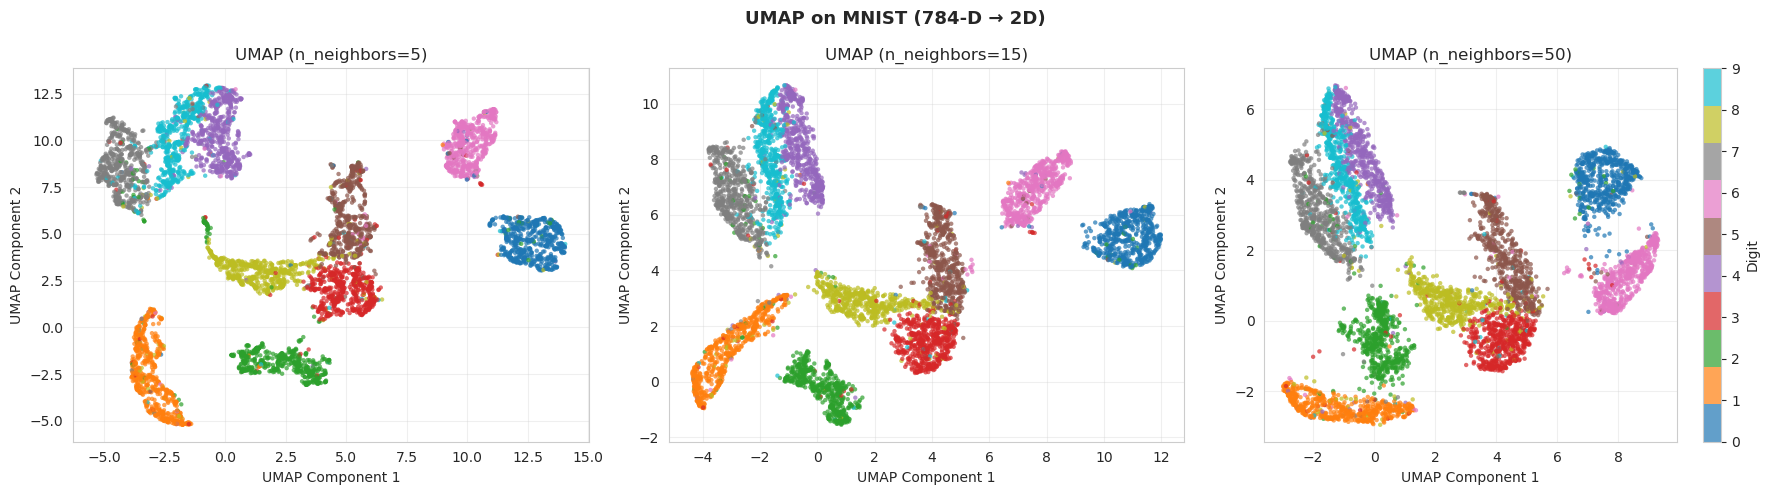


✅ UMAP Observations:
   • Low n_neighbors (5): Very local — fragmented sub-clusters within each digit
   • Medium n_neighbors (15): Classic result — 10 compact, well-separated digit blobs
   • High n_neighbors (50): More global layout; digits still separated but more connected


In [14]:
# Apply UMAP with different n_neighbors values on MNIST
n_neighbors_list = [5, 15, 50]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, n_neighbors in enumerate(n_neighbors_list):
    print(f"Running UMAP with n_neighbors={n_neighbors}...")

    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1,
                           n_components=2, random_state=42)
    X_umap = umap_model.fit_transform(X_mnist)

    scatter = axes[idx].scatter(X_umap[:, 0], X_umap[:, 1],
                                c=y_mnist, cmap='tab10',
                                alpha=0.7, edgecolors='none', s=10)
    axes[idx].set_xlabel('UMAP Component 1')
    axes[idx].set_ylabel('UMAP Component 2')
    axes[idx].set_title(f'UMAP (n_neighbors={n_neighbors})')
    axes[idx].grid(True, alpha=0.3)

    if idx == 2:
        cbar = plt.colorbar(scatter, ax=axes[idx], ticks=range(10))
        cbar.set_label('Digit', fontsize=10)

plt.suptitle('UMAP on MNIST (784-D → 2D)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ UMAP Observations:")
print("   • Low n_neighbors (5): Very local — fragmented sub-clusters within each digit")
print("   • Medium n_neighbors (15): Classic result — 10 compact, well-separated digit blobs")
print("   • High n_neighbors (50): More global layout; digits still separated but more connected")


### UMAP with Different min_dist Values

Running UMAP with min_dist=0.0...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.1...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.5...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


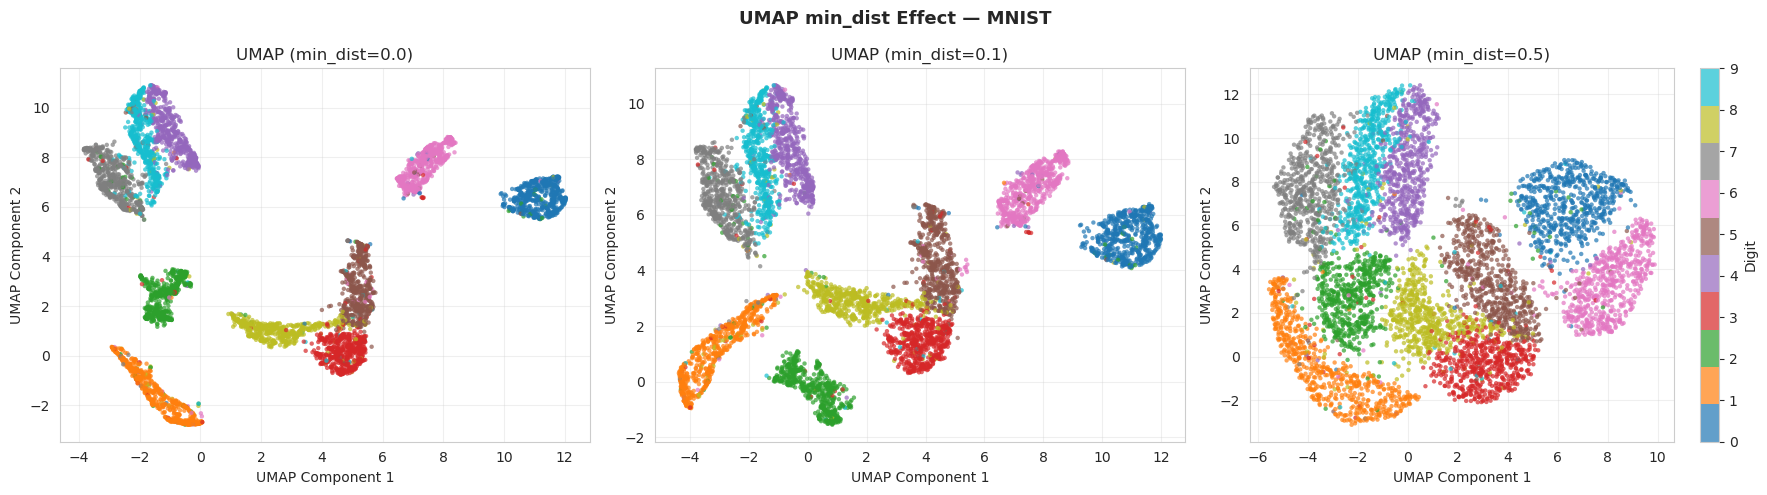


✅ min_dist Observations:
   • min_dist=0.0: Tightly packed blobs — maximum within-cluster density
   • min_dist=0.1: Good default — clusters compact but with visible internal structure
   • min_dist=0.5: Spread-out points — easier to see transitions between digits


In [15]:
# Apply UMAP with different min_dist values on MNIST
min_dist_list = [0.0, 0.1, 0.5]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, min_dist in enumerate(min_dist_list):
    print(f"Running UMAP with min_dist={min_dist}...")

    umap_model = umap.UMAP(n_neighbors=15, min_dist=min_dist,
                           n_components=2, random_state=42)
    X_umap = umap_model.fit_transform(X_mnist)

    scatter = axes[idx].scatter(X_umap[:, 0], X_umap[:, 1],
                                c=y_mnist, cmap='tab10',
                                alpha=0.7, edgecolors='none', s=10)
    axes[idx].set_xlabel('UMAP Component 1')
    axes[idx].set_ylabel('UMAP Component 2')
    axes[idx].set_title(f'UMAP (min_dist={min_dist})')
    axes[idx].grid(True, alpha=0.3)

    if idx == 2:
        cbar = plt.colorbar(scatter, ax=axes[idx], ticks=range(10))
        cbar.set_label('Digit', fontsize=10)

plt.suptitle('UMAP min_dist Effect — MNIST', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ min_dist Observations:")
print("   • min_dist=0.0: Tightly packed blobs — maximum within-cluster density")
print("   • min_dist=0.1: Good default — clusters compact but with visible internal structure")
print("   • min_dist=0.5: Spread-out points — easier to see transitions between digits")



### UMAP Parameters Explained

#### 🔧 `n_neighbors` (default = 15)
Controls **how much of the local vs global structure** UMAP focuses on — the most important parameter.

- Internally, UMAP builds a graph where each point connects to its `n_neighbors` nearest neighbors in high-D space
- **Low (2–5)**: Very local view → captures fine-grained sub-structure within clusters, but loses global layout
- **Medium (10–20)**: Balanced — compact, well-separated clusters with preserved global relationships
- **High (50–200)**: More global view → clusters may connect or merge, but inter-cluster relationships are better preserved

> 💡 Analogous to t-SNE's `perplexity`. Start with 15 and tune from there.

---

#### 🔧 `min_dist` (default = 0.1)
Controls **how tightly points are packed** within clusters in the low-dimensional embedding.

- **0.0**: Points can sit directly on top of each other → maximum density, very tight blobs
- **0.1**: Points have a small minimum separation → compact but with visible internal structure (good default)
- **0.5–1.0**: Points are spread out → easier to see continuous structure and transitions between clusters

> 💡 Use low `min_dist` (0.0–0.1) when you want clear, compact clusters. Use high `min_dist` (0.5+) when you suspect continuous structure (e.g., a trajectory or manifold).

---

#### 🔧 `metric` (default = `"euclidean"`)
The distance function used to measure similarity in the original high-D space.

| Metric | Best For |
|--------|----------|
| `euclidean` | General tabular data, image pixels |
| `cosine` | Text embeddings, NLP features (direction matters more than magnitude) |
| `manhattan` | Sparse or count data |
| `correlation` | When you care about patterns, not absolute values |

---

#### 🔧 `n_components` (default = 2)
Output dimensionality. Unlike t-SNE, UMAP can practically be used with **3D** or even higher dimensions (e.g., 10D) as a preprocessing step for ML — not just for visualization.

---

#### t-SNE vs UMAP Parameters — Side by Side

| | t-SNE | UMAP |
|---|---|---|
| Local/Global balance | `perplexity` | `n_neighbors` |
| Point spread in low-D | *(implicit via learning_rate)* | `min_dist` |
| Distance function | Gaussian (fixed) | `metric` (flexible) |
| Convergence control | `max_iter` | `n_epochs` |


### Comparison: PCA vs t-SNE vs UMAP

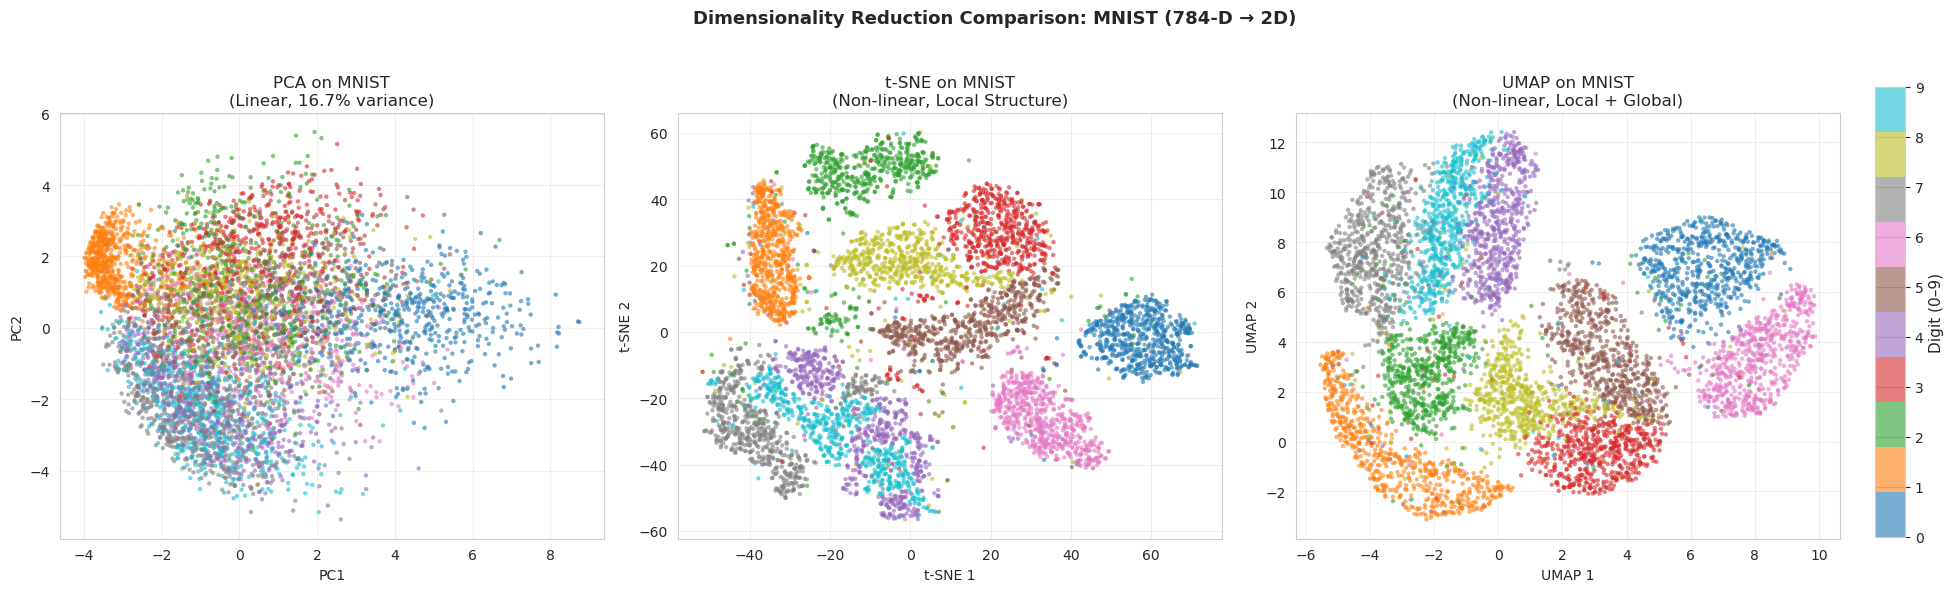


COMPARISON SUMMARY: PCA vs t-SNE vs UMAP  (MNIST, 6 000 images)

Method          Type            Cluster Quality                Speed     
--------------------------------------------------------------------------------
PCA             Linear          Heavy overlap                  ⚡⚡⚡       
t-SNE           Non-linear      10 clear clusters              ⚡         
UMAP            Non-linear      10 compact clusters            ⚡⚡        

🎯 Key Observations on MNIST:
   • PCA: Only ~20% variance in 2D — digits heavily overlap (linear limit)
   • t-SNE: The canonical result — 10 distinct digit clusters (see 2008 paper)
   • UMAP: Similar quality, faster, more consistent run-to-run
   • Both t-SNE and UMAP place similar digits (1&7, 3&5&8, 4&9) near each other

💡 When to Use Each:
   • PCA: Fast preprocessing, interpretable components, data whitening
   • t-SNE: Publication-quality 2D cluster visualisations
   • UMAP: Faster alternative; also usable as a preprocessing step for ML


In [16]:

# Side-by-side comparison of all three methods on MNIST
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# PCA on MNIST (2 components)
pca_mnist = PCA(n_components=2)
X_mnist_pca2 = pca_mnist.fit_transform(X_mnist)
scatter1 = axes[0].scatter(X_mnist_pca2[:, 0], X_mnist_pca2[:, 1],
                           c=y_mnist, cmap='tab10',
                           alpha=0.6, edgecolors='none', s=10)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'PCA on MNIST\n(Linear, {pca_mnist.explained_variance_ratio_.sum():.1%} variance)')
axes[0].grid(True, alpha=0.3)

# t-SNE (reuse from earlier)
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1],
                           c=y_mnist, cmap='tab10',
                           alpha=0.6, edgecolors='none', s=10)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE on MNIST\n(Non-linear, Local Structure)')
axes[1].grid(True, alpha=0.3)

# UMAP (reuse from earlier)
scatter3 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1],
                           c=y_mnist, cmap='tab10',
                           alpha=0.6, edgecolors='none', s=10)
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
axes[2].set_title('UMAP on MNIST\n(Non-linear, Local + Global)')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Dimensionality Reduction Comparison: MNIST (784-D → 2D)',
             fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.93, 0.95])
cbar_ax = fig.add_axes([0.94, 0.1, 0.015, 0.75])
cbar = fig.colorbar(scatter3, cax=cbar_ax, ticks=range(10))
cbar.set_label('Digit (0–9)', fontsize=11)
plt.show()

print("\n" + "=" * 80)
print("COMPARISON SUMMARY: PCA vs t-SNE vs UMAP  (MNIST, 6 000 images)")
print("=" * 80)
print(f"\n{'Method':<15} {'Type':<15} {'Cluster Quality':<30} {'Speed':<10}")
print("-" * 80)
print(f"{'PCA':<15} {'Linear':<15} {'Heavy overlap':<30} {'⚡⚡⚡':<10}")
print(f"{'t-SNE':<15} {'Non-linear':<15} {'10 clear clusters':<30} {'⚡':<10}")
print(f"{'UMAP':<15} {'Non-linear':<15} {'10 compact clusters':<30} {'⚡⚡':<10}")

print("\n🎯 Key Observations on MNIST:")
print("   • PCA: Only ~20% variance in 2D — digits heavily overlap (linear limit)")
print("   • t-SNE: The canonical result — 10 distinct digit clusters (see 2008 paper)")
print("   • UMAP: Similar quality, faster, more consistent run-to-run")
print("   • Both t-SNE and UMAP place similar digits (1&7, 3&5&8, 4&9) near each other")
print("\n💡 When to Use Each:")
print("   • PCA: Fast preprocessing, interpretable components, data whitening")
print("   • t-SNE: Publication-quality 2D cluster visualisations")
print("   • UMAP: Faster alternative; also usable as a preprocessing step for ML")


### ⚠️ Why We Use PCA (Not t-SNE/UMAP) for ML Preprocessing

Despite t-SNE and UMAP producing **visually superior** 2D embeddings, they are **not recommended for ML preprocessing**:

| Property | PCA | t-SNE | UMAP |
|----------|-----|-------|------|
| Can transform new data | ✅ Yes | ❌ No* | ⚠️ Limited |
| Deterministic | ✅ Always | ❌ No | ⚠️ Mostly |
| Preserves distances | ✅ Yes | ❌ No | ❌ No |
| Interpretable components | ✅ Yes | ❌ No | ❌ No |
| Speed on large data | ✅ Fast | ❌ Slow | ⚠️ Medium |

**The core reasons:**

1. **No reliable out-of-sample transform** — t-SNE cannot embed new test points into the same space it learned on training data. Each run re-fits from scratch, so train/test splits are meaningless.

2. **Distances are not preserved** — t-SNE and UMAP distort inter-cluster distances to improve visual separation. ML models that rely on distances (SVM, KNN, linear models) will learn from **artifacts**, not real structure.

3. **They optimize for visual separation, not information retention** — the beautiful clusters you see are partly an illusion. Two clusters that look far apart may not actually be far apart in 784-D space.

4. **Non-determinism** — t-SNE gives different layouts on every run, making reproducible ML pipelines impossible.

> 💡 **Rule of thumb**: Use **t-SNE / UMAP for human eyes** (EDA, papers, presentations).  
> Use **PCA for machines** (preprocessing before training a model).